Starting Training Loop...
[0/30][0/852]	Loss_D: 0.8969	Loss_G: 11.8826	D(x): 0.7622	D(G(z)): 0.4231 / 0.0004
[0/30][64/852]	Loss_D: 0.2078	Loss_G: 18.9865	D(x): 0.8486	D(G(z)): 0.0000 / 0.0000
[0/30][128/852]	Loss_D: 0.2336	Loss_G: 5.5630	D(x): 0.9412	D(G(z)): 0.1444 / 0.0054
[0/30][192/852]	Loss_D: 0.1546	Loss_G: 4.2467	D(x): 0.8739	D(G(z)): 0.0109 / 0.0146
[0/30][256/852]	Loss_D: 0.3274	Loss_G: 5.1010	D(x): 0.8543	D(G(z)): 0.1220 / 0.0108
[0/30][320/852]	Loss_D: 0.4794	Loss_G: 6.7203	D(x): 0.9987	D(G(z)): 0.2814 / 0.0015
[0/30][384/852]	Loss_D: 0.5535	Loss_G: 5.5768	D(x): 0.9089	D(G(z)): 0.2642 / 0.0043
[0/30][448/852]	Loss_D: 0.0606	Loss_G: 4.9394	D(x): 0.9971	D(G(z)): 0.0557 / 0.0077
[0/30][512/852]	Loss_D: 0.5025	Loss_G: 3.0331	D(x): 0.7389	D(G(z)): 0.0300 / 0.0686
[0/30][576/852]	Loss_D: 0.2413	Loss_G: 4.6960	D(x): 0.9597	D(G(z)): 0.1673 / 0.0115
[0/30][640/852]	Loss_D: 0.1422	Loss_G: 5.6193	D(x): 0.8857	D(G(z)): 0.0100 / 0.0048
[0/30][704/852]	Loss_D: 0.1319	Loss_G: 4.6296	D(x):

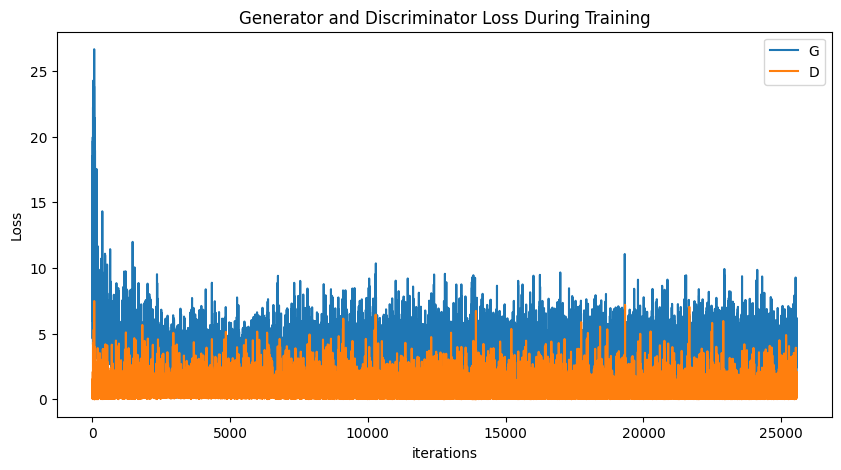

In [4]:
from configparser import ConfigParser
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
from torch.nn.parallel import DataParallel

from make_dl import create_dl
from models.discriminator import Discriminator
from models.generator import Generator


def load_model_conf():
    config = ConfigParser()
    config.read('conf/model_conf.conf')

    handled_conf = {
        "data_path": config['MODEL_CONFIG']['Data_path'],
        "workers": int(config['MODEL_CONFIG']['Workers']),
        "batch_size": int(config['MODEL_CONFIG']['Batch_size']),
        "image_size": int(config['MODEL_CONFIG']['Image_size']),
        "channel_n": int(config['MODEL_CONFIG']['Channel_n']),
        "lat_vec": int(config['MODEL_CONFIG']['Lat_vec']),
        "fm_gen": int(config['MODEL_CONFIG']['Feature_map_gen']),
        "fm_dis": int(config['MODEL_CONFIG']['Feature_map_dis']),
        "num_epochs": int(config['MODEL_CONFIG']['Num_epochs']),
        "lr": float(config['MODEL_CONFIG']['LR']),
        "beta1": float(config['MODEL_CONFIG']['Beta1']),
        "n_gpu": int(config['MODEL_CONFIG']['N_gpu']),
    }
    
    return handled_conf


def weights_init(m) -> None:
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

config = load_model_conf()

device = torch.device("cuda:0" if (torch.cuda.is_available() and config['n_gpu'] > 0) else "cpu")

def train():
    dataloader = create_dl(config['data_path'],
                           config['image_size'],
                           config['batch_size'],
                           config['workers'])
    netG = Generator(config['n_gpu'],
                     config['lat_vec'],
                     config['fm_gen'],
                     config['channel_n']).to(device)

    # Handle multi-gpu if desired
    if (device.type == 'cuda') and (config['n_gpu'] > 1):
        netG = DataParallel(netG, list(range(config['n_gpu'])))

    netG.apply(weights_init)
    netD = Discriminator(config['n_gpu'], config['channel_n'], config['fm_dis']).to(device)

    if (device.type == 'cuda') and (config['n_gpu'] > 1):
        netD = DataParallel(netD, list(range(config['n_gpu'])))

    netD.apply(weights_init)
    
    criterion = nn.BCELoss()
    
    fixed_noise = torch.randn(64, config['lat_vec'], 1, 1, device=device)
    
    real_label = 1.
    fake_label = 0.
    
    optimizerD = optim.Adam(netD.parameters(), lr=config['lr'], betas=(config['beta1'], 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=config['lr'], betas=(config['beta1'], 0.999))
    
    G_losses = []
    D_losses = []
    
    print("Starting Training Loop...")
    Path('train_output').mkdir(parents=True, exist_ok=True)
    
    for epoch in range(config['num_epochs']):
    # For each batch in the dataloader
        for i, data in enumerate(dataloader, 0):

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, config['lat_vec'], 1, 1, device=device)
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 64 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, config['num_epochs'], i, len(dataloader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())
            
            if epoch == config['num_epochs'] - 1 and i == len(dataloader) - 1:
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                imgs = vutils.make_grid(fake, padding=2, normalize=True)
                vutils.save_image(imgs, 'train_output/output.png')
    
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig('train_output/losses.png')
    
    torch.save(netG.state_dict(), 'models/weights/generator_weights.pth')
    torch.save(netD.state_dict(), 'models/weights/discriminator_weights.pth')

train()